# Setup and Library Imports

In [ ]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=7be712ba3c9ccb6319542b93ae8d78aef862693b6f650b7954b2d04875f22b75
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import glob
import os
import random
from tqdm import tqdm
import itertools

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sn


from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import face_recognition

import torchvision
from torchvision import transforms
from torchvision import models
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn

# Dataset Validation

## Frame Extraction

<details>
  <summary><font size="4"><b>Click to expand!</b></font> </summary>
The frame extraction process involves selecting a subset of frames from each video. We aim to capture a representative sample of the video's content while balancing computational efficiency with informational completeness.


In [ ]:
# Define the transform for preprocessing the frames
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((112, 112)),  # Resize frames to 112x112 for consistent model input
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with mean and std for ImageNet
])

def frame_extract(video_path):
    """
    Generator function to extract frames from a video.
    """
    cap = cv2.VideoCapture(video_path)
    while True:
        success, frame = cap.read()
        if not success:
            break
        yield frame
    cap.release()

## Video Validation

In [ ]:
def validate_video(vid_path, train_transforms):
    """
    Validates a video file and extracts a fixed number of frames,
    applying the specified transformations to each frame.
    """
    frames = []
    for frame in frame_extract(vid_path):
        frame = transform(frame)
        frames.append(frame)
        if len(frames) == 20:  # Limit the number of frames extracted to 20
            break
    frames = torch.stack(frames)
    return frames

## Process and Validate Entire Video Dataset

<details>
  <summary><font size="4"><b>Click to expand!</b></font> </summary>
The following code aims to validate video files by checking if they can be processed without errors, which can indicate if a video is corrupted. The code will print detailed information about each corrupted video file and keep track of the total number of processed files.

In [ ]:
# Define the paths to the fake and real video datasets
video_fil = glob.glob('/content/drive/MyDrive/Final Year Project/DFDC_FAKE_Face_only_data/*.mp4')
video_fil += glob.glob('/content/drive/MyDrive/Final Year Project/DFDC_REAL_Face_only_data/*.mp4')

print(f"Total number of videos: {len(video_fil)}")

# Initialize a counter to keep track of how many videos have been processed
count = 0

# Iterate through each video file, applying the validate_video function
for video_path in tqdm(video_fil, desc="Processing Videos"):
    try:
        # Process each video through the validate_video function
        count += 1
        validate_video(video_path, transform)
    except Exception as e:
        # If an error occurs during processing, print the error and continue with the next video
        print(f"Number of videos processed: {count}, Remaining: {len(video_fil) - count}")
        print(f"Corrupted video is: {video_path}")
        print(f"Error: {e}")
        continue

# Print the total number of videos processed successfully
print(f"\nTotal number of videos processed successfully: {count}")


Total number of videos: 3293


Processing Videos: 100%|██████████| 3293/3293 [22:38<00:00,  2.42it/s]


Total number of videos processed successfully: 3293


## Shuffle Dataset and Analyze Frame Counts

<details>
  <summary><font size="4"><b>Click to expand!</b></font> </summary>
The following code loads video files from specified directories, shuffles the list of files, checks if each video has at least 100 frames, and calculates the average frame count per video.


In [ ]:

# Load the video file paths
video_files = glob.glob('/content/drive/MyDrive/Final Year Project/DFDC_FAKE_Face_only_data/*.mp4')
video_files += glob.glob('/content/drive/MyDrive/Final Year Project/DFDC_REAL_Face_only_data/*.mp4')

# Shuffle the dataset to ensure random distribution
random.shuffle(video_files)
random.shuffle(video_files)  # Double shuffling to ensure thorough randomness

frame_count = []

# Analyze the frame count for each video and remove videos with insufficient frames
for video_file in video_files:
    cap = cv2.VideoCapture(video_file)
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if num_frames < 125:  # Exclude videos with less than 100 frames
        video_files.remove(video_file)
        continue

    frame_count.append(num_frames)
    cap.release()

# Print frame count statistics
print(f"Frames are: {frame_count}")
print(f"Total number of videos: {len(frame_count)}")
# print(f"Total number of videos++++: {len(video_files)}")
print(f'Average frame per video: {np.mean(frame_count)}')


Frames are: [148, 148, 145, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 132, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 126, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 146, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 137, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 14

# Dataset Preparation

## Video Dataset Class Definition

<details>
  <summary><font size="4"><b>Click to expand!</b></font> </summary>
The following code defines a `video_dataset` class for loading and transforming video frames from specified video paths and labels, which are presumably read from a CSV file. The class is designed to work with PyTorch's DataLoader for batching and processing video data.

In [ ]:
class video_dataset(Dataset):
    """
    A custom dataset class that extends PyTorch's Dataset for handling video files.
    """
    def __init__(self, video_names, labels, sequence_length=60, transform=None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self, idx):
        video_path = self.video_names[idx]
        label = self.labels.loc[self.labels['file'] == video_path.split('/')[-1], 'label'].values[0]
        label = 0 if label == 'FAKE' else 1
        frames = [self.transform(frame) for frame in itertools.islice(self.frame_extract(video_path), self.sequence_length)]
        return torch.stack(frames), label

    def frame_extract(self, path):
        cap = cv2.VideoCapture(path)
        while True:
            success, frame = cap.read()
            if not success:
                break
            yield frame
        cap.release()

In [ ]:
import logging
from torch.utils.data import Dataset
import cv2
import itertools
import torch

# Configure logging
logging.basicConfig(level=logging.DEBUG, filename='dataset_debug.log')

class video_dataset(Dataset):
    """
    A custom dataset class that extends PyTorch's Dataset for handling video files.
    """
    def __init__(self, video_names, labels, sequence_length=60, transform=None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self, idx):
        video_path = self.video_names[idx]
        try:
            # Log the video path and index
            logging.debug(f'Loading video at index {idx}: {video_path}')

            label = self.labels.loc[self.labels['file'] == video_path.split('/')[-1], 'label'].values[0]
            label = 0 if label == 'FAKE' else 1
            frames = [self.transform(frame) for frame in itertools.islice(self.frame_extract(video_path), self.sequence_length)]

            # Check if frames are extracted correctly
            if not frames:
                raise ValueError(f"No frames extracted for video: {video_path}")

            # Log the number of frames extracted
            logging.debug(f'Number of frames extracted for video {video_path}: {len(frames)}')

            # Stack the frames and return with the label
            return torch.stack(frames), label
        except Exception as e:
            # Log the exception
            logging.error(f'Exception at index {idx}: {e}')
            # Optionally, re-raise the exception to halt the program and debug
            raise e

    def frame_extract(self, path):
        cap = cv2.VideoCapture(path)
        while True:
            success, frame = cap.read()
            if not success:
                break
            yield frame
        cap.release()

## Utility Functions

In [ ]:
def im_plot(tensor):
    """
    Function to plot a tensor image.
    """
    image = tensor.cpu().numpy().transpose(1, 2, 0)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    plt.imshow(image)
    plt.show()

def number_of_real_and_fake_videos(data_list):
  header_list = ["file","label"]
  lab = pd.read_csv('/content/drive/MyDrive/Final Year Project/Gobal_metadata.csv',names=header_list)

  fake = 0
  real = 0
  for i in data_list:
    temp_video = i.split('/')[-1]
    label = lab.iloc[(lab.loc[lab["file"] == temp_video].index.values[0]),1]
    if(label == 'FAKE'):
      fake+=1
    if(label == 'REAL'):
      real+=1
  return real,fake

## Initialize Data Loaders

<details>
  <summary><font size="4"><b>Click to expand!</b></font> </summary>
The following code loads video file paths and their corresponding labels from a CSV file, then splits the data into training and validation sets. It also creates data loaders for each set to be used in training and validation processes.

- **Data Splitting**: The `train_test_split` function from `sklearn` is utilized to randomly split the video files into training and validation sets.
- **Dataset Preparation**: The `video_dataset` class is instantiated with the training and validation video paths, along with their transformations.
- **Data Loader Creation**: `DataLoader` objects are created for both training and validation datasets, specifying the batch size and other parameters like shuffling and number of worker threads.
- **Data Visualization**: The `im_plot` function is called to visualize the first frame of the first video from the training set to ensure that the data loading process is working correctly.

In [ ]:
IMG_SIZE = 112
MAX_SEQ_LENGTH = 120

BATCH_SIZE = 4
EPOCHS = 20

LEARNING_RATE = 1e-5
NUM_FEATURES = 2048

In [ ]:
len(video_files)


3253

In [ ]:
# Load labels and video file names
header_list = ["file","label"]
labels = pd.read_csv('/content/drive/MyDrive/Final Year Project/Gobal_metadata.csv',names=header_list)

# Split video files into training and validation sets
train_videos, valid_videos = train_test_split(video_files, test_size=0.3)

print("Train videos count:", len(train_videos))
print("Validation videos count:", len(valid_videos))

# Print the count of real and fake videos in each set
print("TRAIN: ", "Real:",number_of_real_and_fake_videos(train_videos)[0]," Fake:",number_of_real_and_fake_videos(train_videos)[1])
print("TEST: ", "Real:",number_of_real_and_fake_videos(valid_videos)[0]," Fake:",number_of_real_and_fake_videos(valid_videos)[1])


# Transformations for the video frames
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Create the custom dataset instances for training and validation
train_data = video_dataset(train_videos, labels, sequence_length=MAX_SEQ_LENGTH, transform=transform)
val_data = video_dataset(valid_videos, labels, sequence_length=MAX_SEQ_LENGTH, transform=transform)

# Initialize the DataLoader for both training and validation sets
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Train videos count: 2277
Validation videos count: 976
TRAIN:  Real: 1191  Fake: 1086
TEST:  Real: 522  Fake: 454


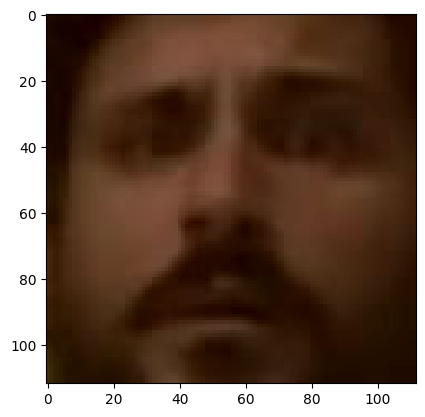

In [ ]:
# Fetch the first batch of data to display
sample_image, sample_label = train_data[0]
im_plot(sample_image[0])  # Plot the first frame of the first video in the batch

# Modeling

## Model Definition

<details>
  <summary><font size="4"><b>Click to expand!</b></font> </summary>
The following code defines `Model` class for a video classification task, integrating a CNN (ResNet-based architecture) and an LSTM for sequence processing.

**Model Architecture**
- **ResNeXt50**: We use the ResNeXt50 architecture, a variant of the ResNet model known for its efficiency and performance in image classification tasks. The model is pre-trained on ImageNet, allowing us to leverage transfer learning for better feature extraction capabilities.
- **LSTM**: Following the CNN layers, we incorporate LSTM layers to analyze the temporal sequence of frames and understand the video's dynamics.
- **Dropout and Fully Connected Layer**: To prevent overfitting, a dropout layer is applied, followed by a fully connected layer to classify the video as real or fake.

**Forward Pass**

In the `forward` method, we define how the data flows through the model, including reshaping tensors to fit the LSTM's input requirements and aggregating the sequence of LSTM outputs to form a final prediction.

In [ ]:
class Model(nn.Module):
    def __init__(self, num_classes, latent_dim=NUM_FEATURES, lstm_layers=1, hidden_dim=NUM_FEATURES, bidirectional=False):
        """
        A deep learning model combining CNN and LSTM for video classification.

        :param num_classes: Number of output classes
        :param latent_dim: The number of expected features in the input for the LSTM
        :param lstm_layers: Number of recurrent layers in the LSTM
        :param hidden_dim: The number of features in the hidden state of the LSTM
        :param bidirectional: If True, becomes a bidirectional LSTM
        """
        super(Model, self).__init__()

        # Load a pre-trained ResNeXt model and remove its final layers
        model = models.resnext50_32x4d(weights='DEFAULT')
        self.model = nn.Sequential(*list(model.children())[:-2])

        # Define LSTM, ReLU, Dropout, and Linear layers
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional=bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(hidden_dim, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)


    def forward(self, x):
        # Reshape x to fit the CNN
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)

        # Apply average pooling and prepare LSTM input
        x = self.avgpool(fmap)
        x = x.view(batch_size, seq_length, -1)

        # Process through LSTM and linear layers
        x_lstm, _ = self.lstm(x)
        x = self.dp(self.linear1(torch.mean(x_lstm, dim=1)))

        return fmap, x

In [ ]:
from torchsummary import summary
# Instantiate the model and move it to GPU if available
model = Model(num_classes=2).cuda()

# Print the model summary
#summary(model, input_size = (10, 3, 112, 112), batch_size = 4)
print(model)

Model(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

## Training and Testing the Model


<details>
  <summary><font size="4"><b>Click to expand!</b></font> </summary>

The following script defines functions for training and testing a PyTorch model, including utilities for tracking performance metrics such as loss and accuracy. It's structured to handle data loading, model training/testing, and performance evaluation.

1. **`train_epoch` function**: Handles a single training epoch, iterating over the data loader, computing the loss and accuracy, and updating the model parameters.

2. **`test` function**: Evaluates the model performance on the test dataset, computing the loss and accuracy without updating the model parameters.

3. **`AverageMeter` class**: Utility for tracking the average, sum, and current values of metrics like loss and accuracy.

4. **`calculate_accuracy` function**: Computes the accuracy of the model's predictions against the ground truth labels.

In [ ]:
# Define the training function
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()  # Set the model to training mode
    losses = AverageMeter()
    accuracies = AverageMeter()

    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.cuda()
            inputs = inputs.cuda()

        optimizer.zero_grad()
        _, outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        losses.update(loss.item(), inputs.size(0))
        acc = calculate_accuracy(outputs, targets)
        accuracies.update(acc, inputs.size(0))

        print(f"\r[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(data_loader)}] [Loss: {losses.avg:.6f}, Acc: {accuracies.avg:.2f}%]", end="")
    print('\n')
    torch.save(model.state_dict(), '/content/checkpoint.pt')  # Save the model checkpoint
    return losses.avg, accuracies.avg

# Define the testing function
def test(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda()
                inputs = inputs.cuda()

            _,outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets))
            acc = calculate_accuracy(outputs,targets)

            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))

            _,p = torch.max(outputs,1)
            true += targets.detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()

            print(f"\r[Test] Loss: {losses.avg:.6f}, Acc: {accuracies.avg:.2f}%", end="")

    return true, pred, losses.avg, accuracies.avg

In [ ]:
# Utility class for tracking average values
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0  # Value for the latest update
        self.avg = 0  # Running average
        self.sum = 0  # Sum of the values
        self.count = 0  # Number of updates

    def update(self, val, n=1):
        """
        Updates the meter with new value.

        :param val: Value to update with
        :param n: Number of elements the value represents
        """
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Function to calculate accuracy
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)
    _, preds = outputs.max(1)
    correct = preds.eq(targets).sum()
    return 100.0 * correct / batch_size

## Execute Training and Testing

In [ ]:
 # Initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Initialize the criterion
criterion = nn.CrossEntropyLoss().cuda()  # Using CrossEntropyLoss for classification

# Lists to store loss and accuracy for plotting
train_loss_avg = []
train_accuracy = []
test_loss_avg = []
test_accuracy = []

# Training and evaluation loop
for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_epoch(epoch, EPOCHS, train_loader, model, criterion, optimizer)
    true_labels, pred_labels, test_loss, test_acc = test(model, valid_loader, criterion)

    # Append loss and accuracy to the lists
    train_loss_avg.append(train_loss)
    train_accuracy.append(train_acc)
    test_loss_avg.append(test_loss)
    test_accuracy.append(test_acc)

    print(f"\nEpoch {epoch}/{EPOCHS} completed: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print("="*50,"\n")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Epoch 1/20] [Batch 569/570] [Loss: 0.667058, Acc: 57.31%]

[Test] Loss: 0.586921, Acc: 73.36%
Epoch 1/20 completed: Train Loss: 0.6671, Train Acc: 57.31%, Test Loss: 0.5869, Test Acc: 73.36%

[Epoch 2/20] [Batch 569/570] [Loss: 0.566858, Acc: 69.87%]

[Test] Loss: 0.453341, Acc: 81.35%
Epoch 2/20 completed: Train Loss: 0.5669, Train Acc: 69.87%, Test Loss: 0.4533, Test Acc: 81.35%

[Epoch 3/20] [Batch 569/570] [Loss: 0.482571, Acc: 73.78%]

[Test] Loss: 0.393141, Acc: 83.61%
Epoch 3/20 completed: Train Loss: 0.4826, Train Acc: 73.78%, Test Loss: 0.3931, Test Acc: 83.61%

[Epoch 4/20] [Batch 569/570] [Loss: 0.419037, Acc: 77.95%]

[Test] Loss: 0.337692, Acc: 86.37%
Epoch 4/20 completed: Train Loss: 0.4190, Train Acc: 77.95%, Test Loss: 0.3377, Test Acc: 86.37%

[Epoch 5/20] [Batch 569/570] [Loss: 0.377508, Acc: 80.46%]

[Test] Loss: 0.324557, Acc: 87.50%
Epoch 5/20 completed: Train Loss: 0.3775, Train Acc: 80.46%, Test Loss: 0.3246, Test Acc: 87.50%

[Epoch 6/20] [Batch 569/570] [Loss:

In [ ]:
# Initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Initialize the criterion
criterion = nn.CrossEntropyLoss().cuda()  # Using CrossEntropyLoss for classification

# Lists to store loss and accuracy for plotting
train_loss_avg = []
train_accuracy = []
test_loss_avg = []
test_accuracy = []

# Early stopping parameters
best_val_loss = float('inf')
patience = 2  # How many epochs to wait after last time validation loss improved.
wait = 0  # The counter for patience; how long we have waited for validation loss to improve.

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_epoch(epoch, EPOCHS, train_loader, model, criterion, optimizer)
    true_labels, pred_labels, val_loss, val_acc = test(model, valid_loader, criterion)

    # Append loss and accuracy to the lists
    train_loss_avg.append(train_loss)
    train_accuracy.append(train_acc)
    test_loss_avg.append(val_loss)
    test_accuracy.append(val_acc)

    print(f"\nEpoch {epoch}/{EPOCHS} completed: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print("="*50,"\n")

    # Check if the validation loss improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        # Save the best model
        torch.save(model.state_dict(), '/content/best_model.pt')
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch}")
            break  # early stop condition was met, we can stop now


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Epoch 1/20] [Batch 569/570] [Loss: 0.670239, Acc: 55.51%]

[Test] Loss: 0.590779, Acc: 69.19%
Epoch 1/20 completed: Train Loss: 0.6702, Train Acc: 55.51%, Val Loss: 0.5908, Val Acc: 69.19%

[Epoch 2/20] [Batch 569/570] [Loss: 0.552891, Acc: 70.25%]

[Test] Loss: 0.450411, Acc: 78.40%
Epoch 2/20 completed: Train Loss: 0.5529, Train Acc: 70.25%, Val Loss: 0.4504, Val Acc: 78.40%

[Epoch 3/20] [Batch 569/570] [Loss: 0.467640, Acc: 76.17%]

[Test] Loss: 0.389277, Acc: 83.52%
Epoch 3/20 completed: Train Loss: 0.4676, Train Acc: 76.17%, Val Loss: 0.3893, Val Acc: 83.52%

[Epoch 4/20] [Batch 569/570] [Loss: 0.429512, Acc: 77.58%]

[Test] Loss: 0.343981, Acc: 85.16%
Epoch 4/20 completed: Train Loss: 0.4295, Train Acc: 77.58%, Val Loss: 0.3440, Val Acc: 85.16%

[Epoch 5/20] [Batch 569/570] [Loss: 0.397130, Acc: 79.03%]

[Test] Loss: 0.293057, Acc: 88.23%
Epoch 5/20 completed: Train Loss: 0.3971, Train Acc: 79.03%, Val Loss: 0.2931, Val Acc: 88.23%

[Epoch 6/20] [Batch 569/570] [Loss: 0.377472,

# Evaluation

## Accuracy & Loss Plots

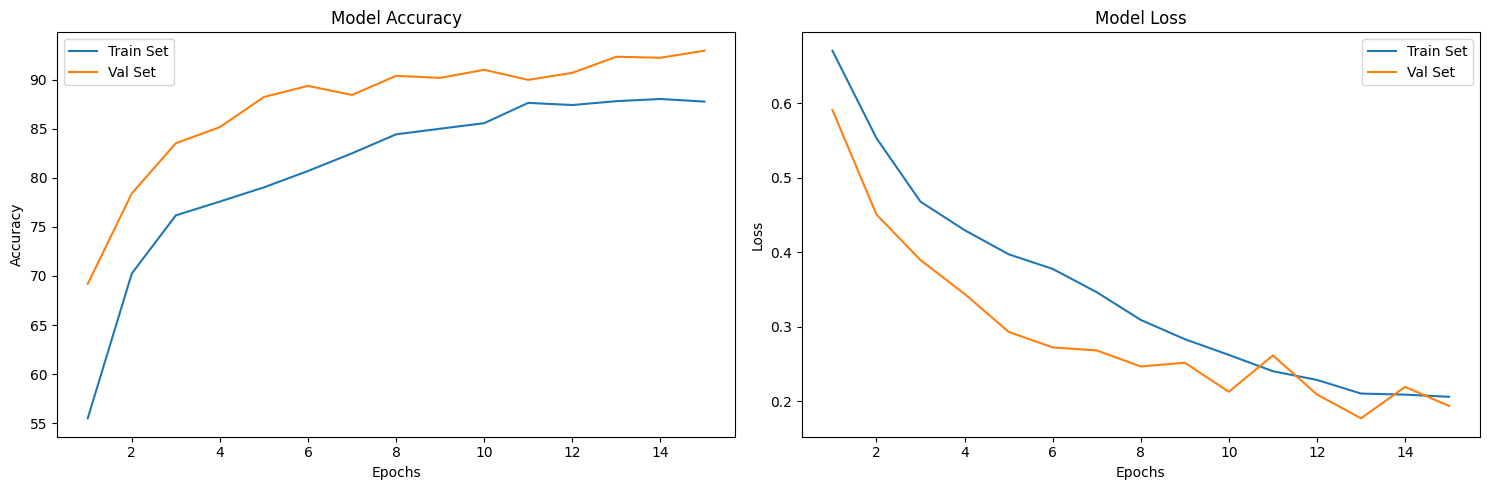

In [ ]:
#epochs = range(1, EPOCHS + 1)
epochs=range(1,16)
plt.figure(figsize=(15,5))

acc_train = [item.tolist() for item in train_accuracy]
acc_val = [item.tolist() for item in test_accuracy]

# plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_train, label='Train Set')

plt.plot(epochs, acc_val, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

# plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_avg, label='Train Set')
plt.plot(epochs, test_loss_avg, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

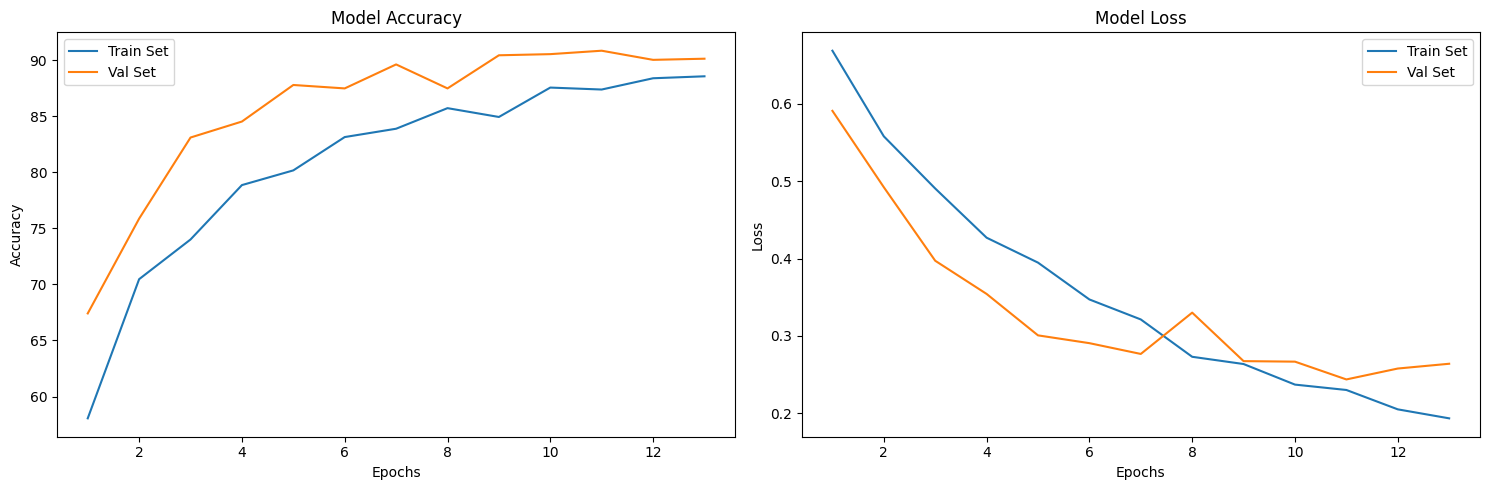

In [ ]:
#epochs = range(1, EPOCHS + 1)
epochs=range(1,14)
plt.figure(figsize=(15,5))

acc_train = [item.tolist() for item in train_accuracy]
acc_val = [item.tolist() for item in test_accuracy]

# plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_train, label='Train Set')

plt.plot(epochs, acc_val, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

# plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_avg, label='Train Set')
plt.plot(epochs, test_loss_avg, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

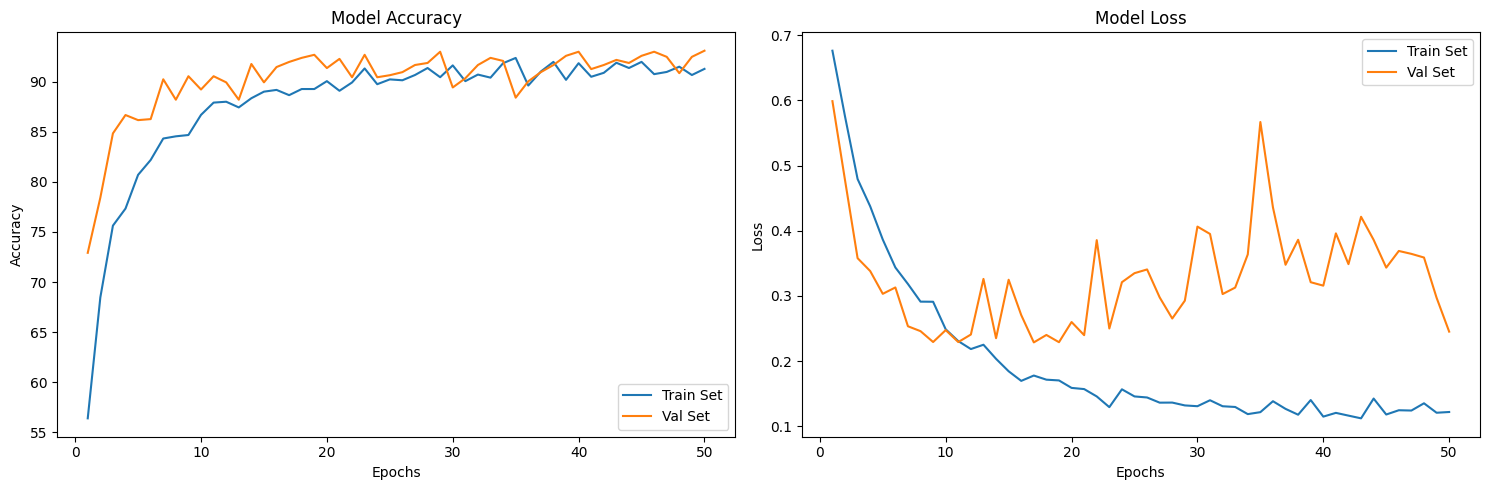

In [ ]:
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(15,5))

acc_train = [item.tolist() for item in train_accuracy]
acc_val = [item.tolist() for item in test_accuracy]

# plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_train, label='Train Set')
plt.plot(epochs, acc_val, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

# plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_avg, label='Train Set')
plt.plot(epochs, test_loss_avg, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

True positive = 446
False positive = 35
False negative = 33
True negative = 468



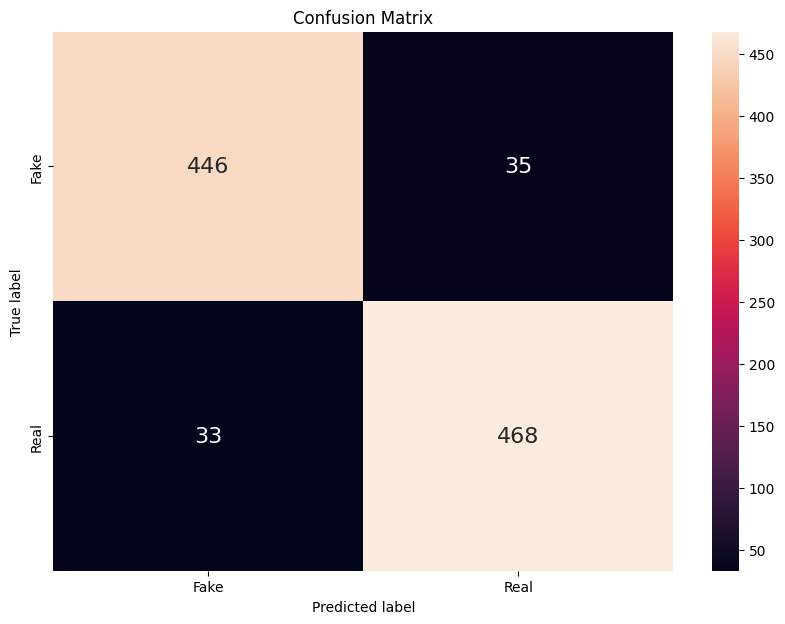

Calculated Accuracy: 93.07535641547861%


In [ ]:
# Display the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
print(f'True positive = {cm[0][0]}')
print(f'False positive = {cm[0][1]}')
print(f'False negative = {cm[1][0]}')
print(f'True negative = {cm[1][1]}\n')

df_cm = pd.DataFrame(cm, index=['Fake', 'Real'], columns=['Fake', 'Real'])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True, fmt='g', annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

calculated_acc = (cm[0][0] + cm[1][1]) / cm.sum() * 100
print(f"Calculated Accuracy: {calculated_acc}%")

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, pred_labels, target_names=['Fake', 'Real'])
print(report)

              precision    recall  f1-score   support

        Fake       0.93      0.91      0.92       438
        Real       0.93      0.95      0.94       539

    accuracy                           0.93       977
   macro avg       0.93      0.93      0.93       977
weighted avg       0.93      0.93      0.93       977



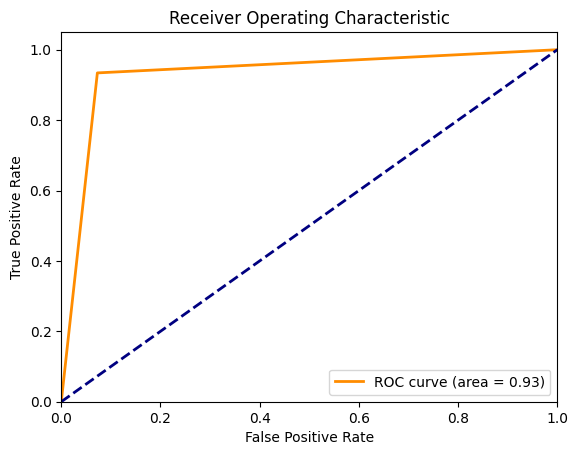

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    true_labels = []
    pred_labels = []
    all_images = []

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)

            _,outputs = model(data)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
            all_images.extend(data.cpu())

    return true_labels, pred_labels, all_images

# Evaluate the model
true_labels, pred_labels, all_images = evaluate_model(model, valid_loader)

misclassified_indices = [i for i, (true, pred) in enumerate(zip(true_labels, pred_labels)) if true != pred]
misclassified_images = [all_images[i] for i in misclassified_indices]

len(misclassified_images)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


66

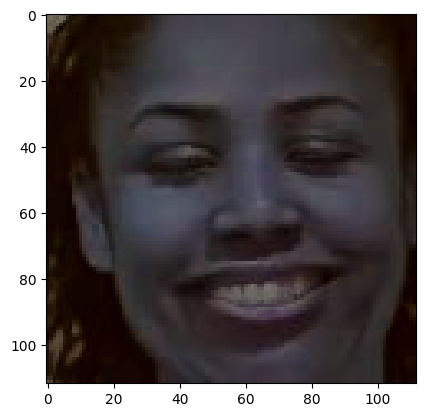

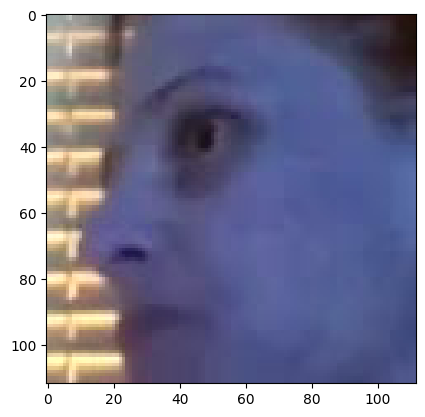

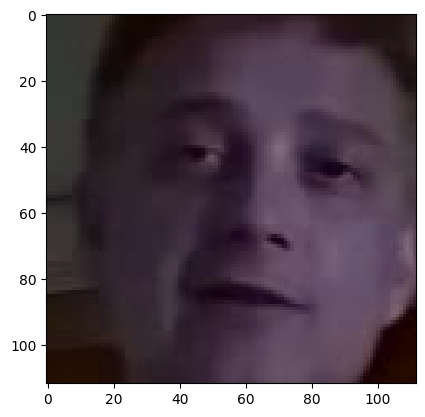

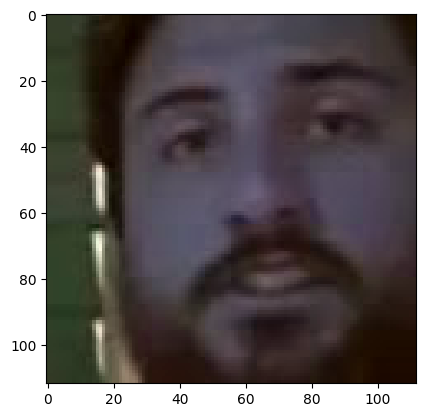

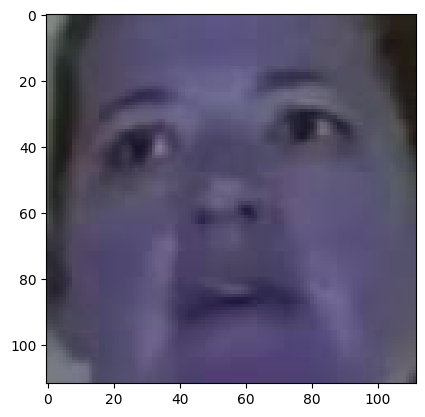

In [ ]:
# Visualize misclassified examples
for image in misclassified_images[:5]:
      im_plot(image[0])
      # plt.title("Misclassified Example")
      # plt.show()

## Confusion Matrix

## Class-wise Performance



## ROC Curve and AUC



# Evaluation For First model (20 frames)

---------------------------

20


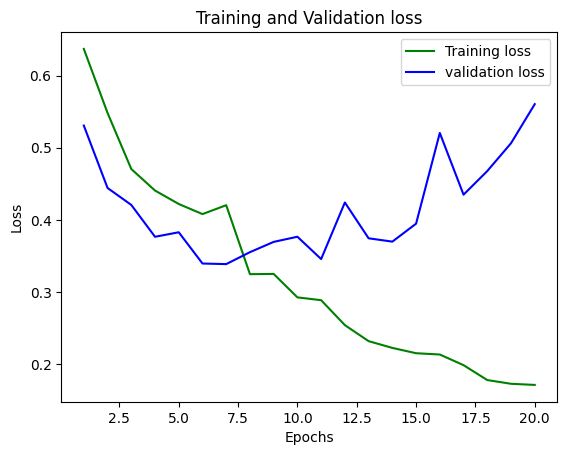

In [ ]:
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))

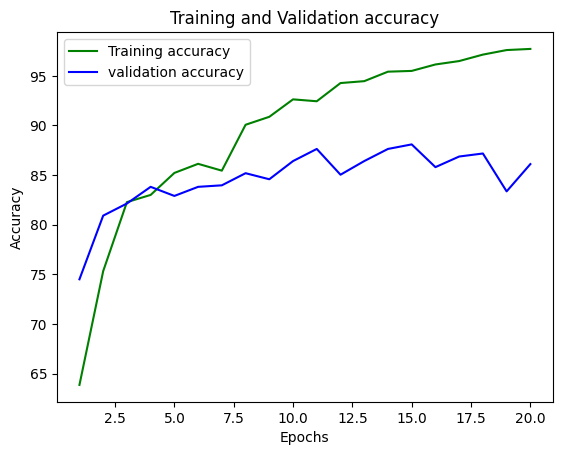

In [ ]:
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))

## Confusion Matrix

True positive =  262
False positive =  52
False negative =  39
True negative =  302




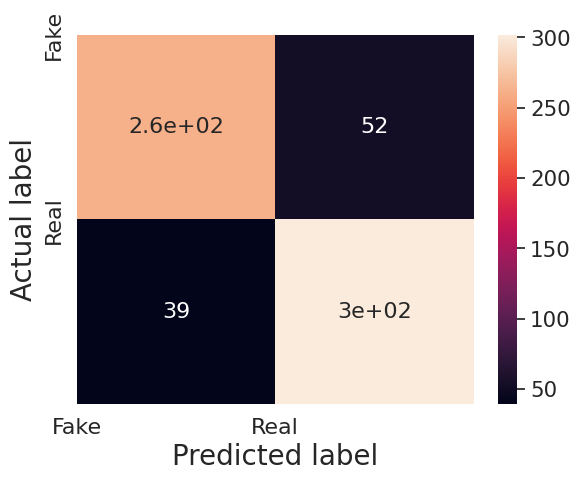

Calculated Accuracy 86.10687022900764


In [ ]:
print_confusion_matrix(true,pred)

## Class-wise Performance

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, pred_labels, target_names=['Fake', 'Real'])
print(report)

              precision    recall  f1-score   support

        Fake       0.88      0.92      0.90       479
        Real       0.92      0.88      0.90       503

    accuracy                           0.90       982
   macro avg       0.90      0.90      0.90       982
weighted avg       0.90      0.90      0.90       982



## ROC Curve and AUC

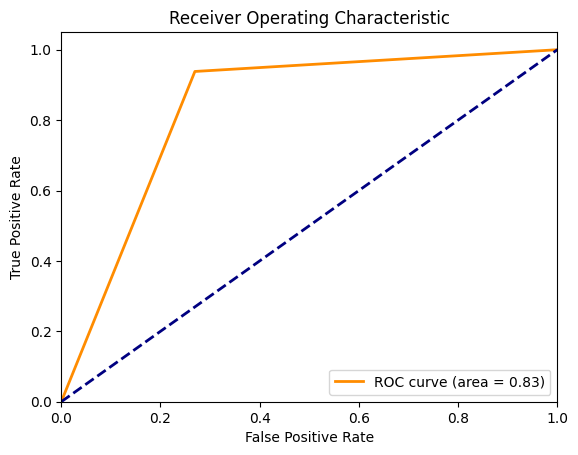

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Save the trained model
model_save_path = '/content/drive/MyDrive/Colab Notebooks/model_89_acc_120_frames_20epoch.pt'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to /content/drive/MyDrive/Colab Notebooks/model_89_acc_120_frames_20epoch.pt



# Evaluation For Second model (60 frames)

-----------------------------------

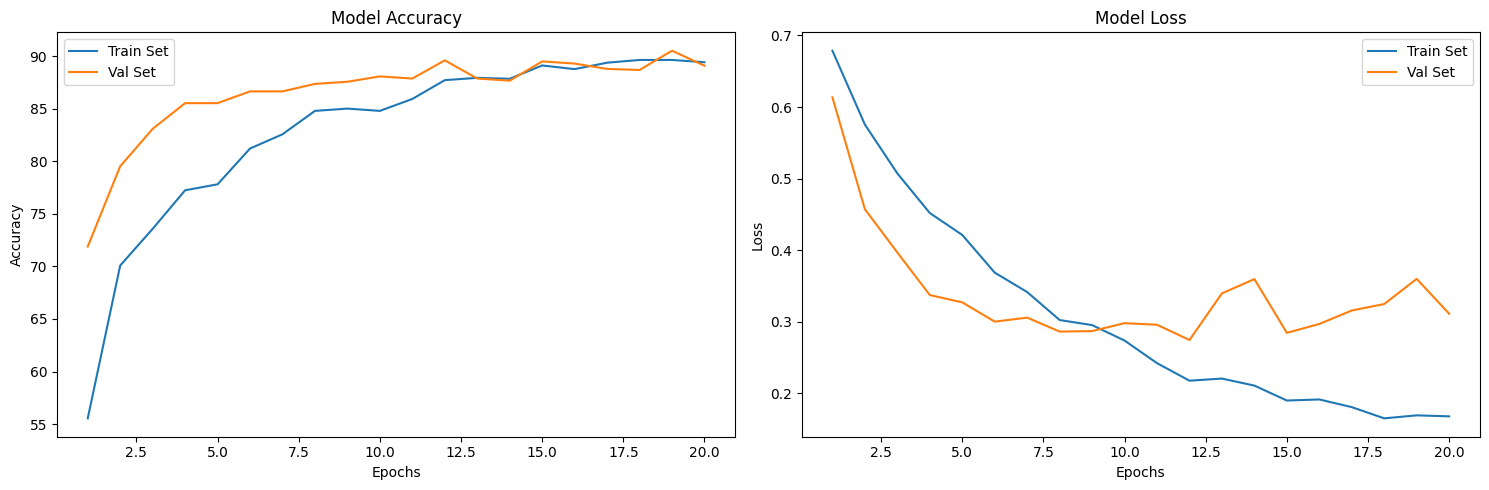

In [ ]:
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(15,5))

acc_train = [item.tolist() for item in train_accuracy]
acc_val = [item.tolist() for item in test_accuracy]

# plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_train, label='Train Set')
plt.plot(epochs, acc_val, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

# plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_avg, label='Train Set')
plt.plot(epochs, test_loss_avg, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

## Confusion Matrix

True positive = 434
False positive = 33
False negative = 74
True negative = 441



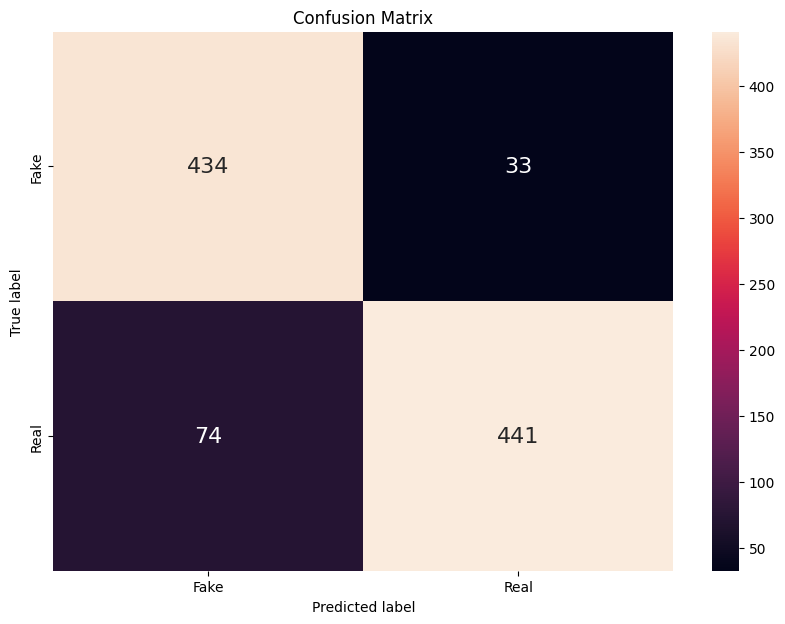

Calculated Accuracy: 89.10386965376782%


In [ ]:
# Display the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
print(f'True positive = {cm[0][0]}')
print(f'False positive = {cm[0][1]}')
print(f'False negative = {cm[1][0]}')
print(f'True negative = {cm[1][1]}\n')

df_cm = pd.DataFrame(cm, index=['Fake', 'Real'], columns=['Fake', 'Real'])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True, fmt='g', annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

calculated_acc = (cm[0][0] + cm[1][1]) / cm.sum() * 100
print(f"Calculated Accuracy: {calculated_acc}%")


## Class-wise Performance

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, pred_labels, target_names=['Fake', 'Real'])
print(report)

              precision    recall  f1-score   support

        Fake       0.85      0.93      0.89       467
        Real       0.93      0.86      0.89       515

    accuracy                           0.89       982
   macro avg       0.89      0.89      0.89       982
weighted avg       0.89      0.89      0.89       982



## ROC Curve and AUC

```
# This is formatted as code
```



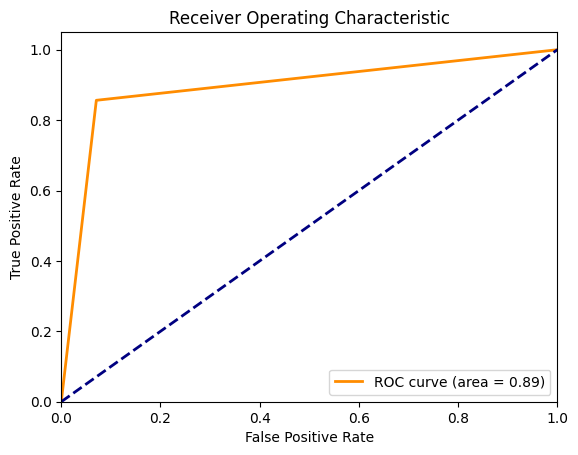

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Visualize Misclassified


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    true_labels = []
    pred_labels = []
    all_images = []

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)

            _,outputs = model(data)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
            all_images.extend(data.cpu())

    return true_labels, pred_labels, all_images

# Evaluate the model
true_labels, pred_labels, all_images = evaluate_model(model, valid_loader)

misclassified_indices = [i for i, (true, pred) in enumerate(zip(true_labels, pred_labels)) if true != pred]
misclassified_images = [all_images[i] for i in misclassified_indices]

len(misclassified_images)

113

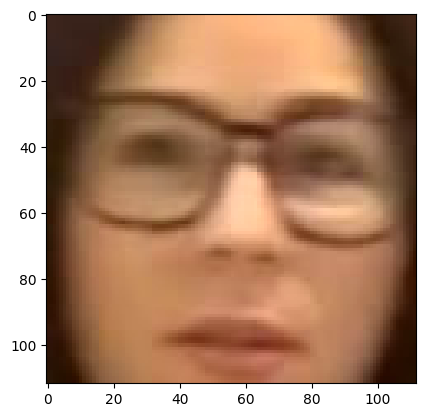

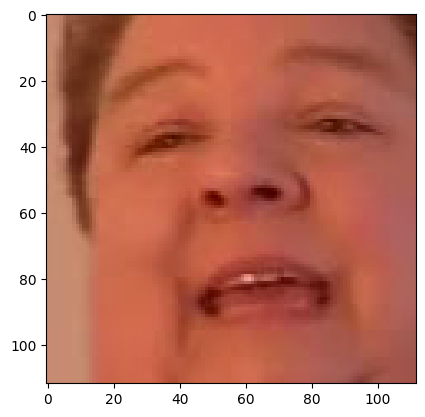

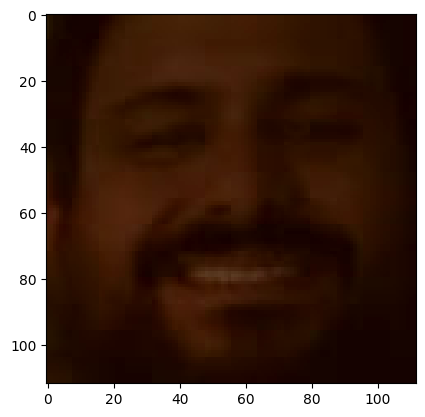

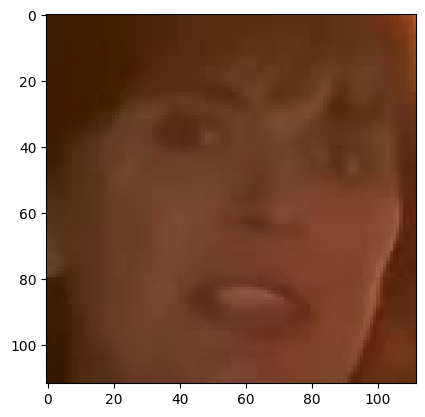

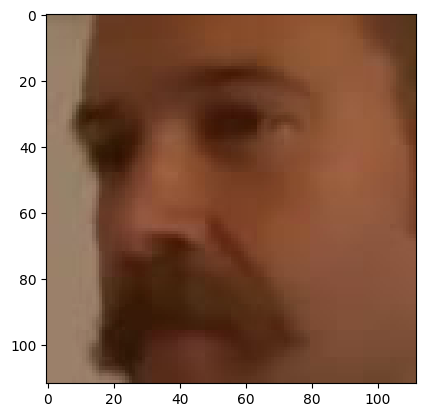

In [ ]:
# Visualize misclassified examples
for image in misclassified_images[:5]:
      im_plot(image[0])
      # plt.title("Misclassified Example")
      # plt.show()

# Evaluation For **third** model (80 frames)


--------

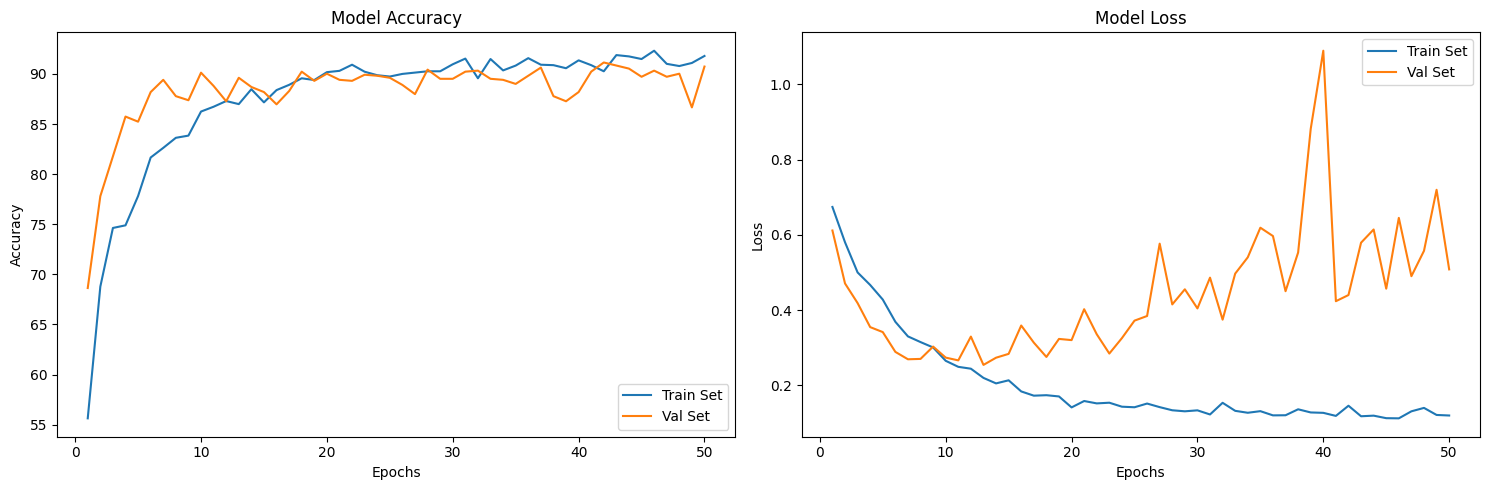

In [ ]:
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(15,5))

acc_train = [item.tolist() for item in train_accuracy]
acc_val = [item.tolist() for item in test_accuracy]

# plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_train, label='Train Set')
plt.plot(epochs, acc_val, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

# plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_avg, label='Train Set')
plt.plot(epochs, test_loss_avg, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

## Confusion Matrix

True positive = 451
False positive = 31
False negative = 60
True negative = 440



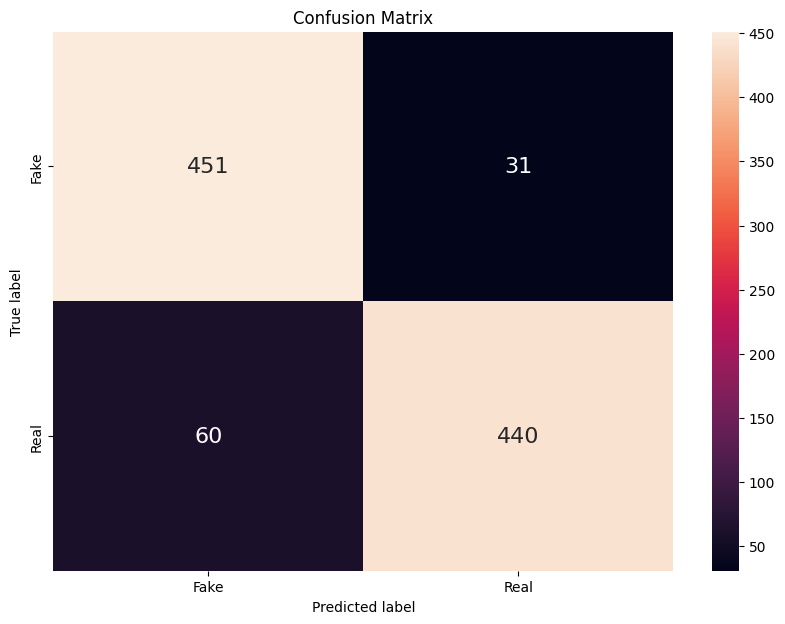

Calculated Accuracy: 90.73319755600815%


In [ ]:
# Display the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
print(f'True positive = {cm[0][0]}')
print(f'False positive = {cm[0][1]}')
print(f'False negative = {cm[1][0]}')
print(f'True negative = {cm[1][1]}\n')

df_cm = pd.DataFrame(cm, index=['Fake', 'Real'], columns=['Fake', 'Real'])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True, fmt='g', annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

calculated_acc = (cm[0][0] + cm[1][1]) / cm.sum() * 100
print(f"Calculated Accuracy: {calculated_acc}%")

## Class-wise Performance

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, pred_labels, target_names=['Fake', 'Real'])
print(report)

              precision    recall  f1-score   support

        Fake       0.88      0.94      0.91       482
        Real       0.93      0.88      0.91       500

    accuracy                           0.91       982
   macro avg       0.91      0.91      0.91       982
weighted avg       0.91      0.91      0.91       982



## ROC Curve and AUC


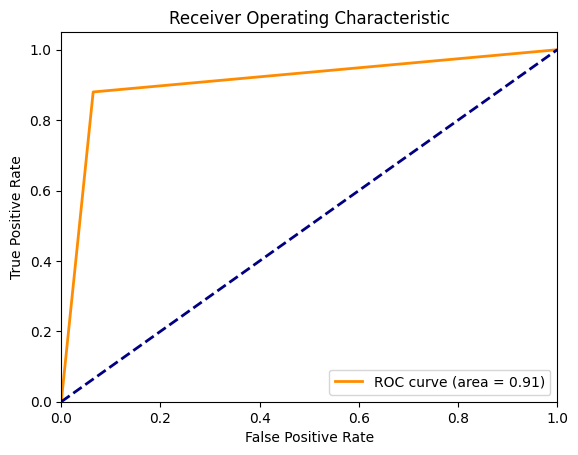

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Visualize Misclassified






In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    true_labels = []
    pred_labels = []
    all_images = []

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)

            _,outputs = model(data)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
            all_images.extend(data.cpu())

    return true_labels, pred_labels, all_images

# Evaluate the model
true_labels, pred_labels, all_images = evaluate_model(model, valid_loader)

misclassified_indices = [i for i, (true, pred) in enumerate(zip(true_labels, pred_labels)) if true != pred]
misclassified_images = [all_images[i] for i in misclassified_indices]

len(misclassified_images)

95

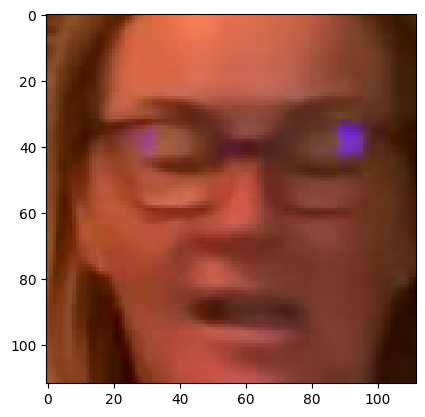

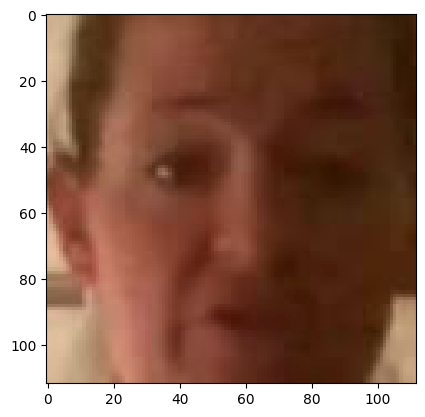

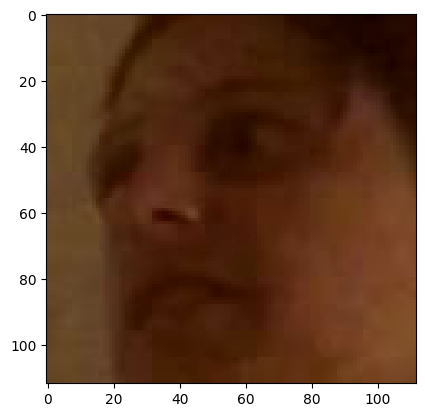

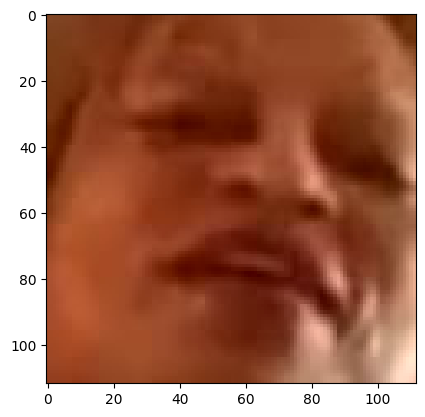

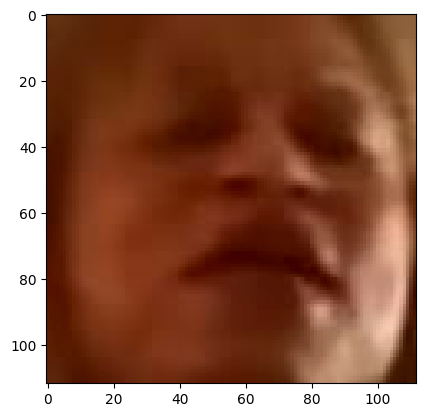

In [ ]:
# Visualize misclassified examples
for image in misclassified_images[:5]:
      im_plot(image[0])
      # plt.title("Misclassified Example")
      # plt.show()

# Evaluation For **forth** model (100 frames)

---




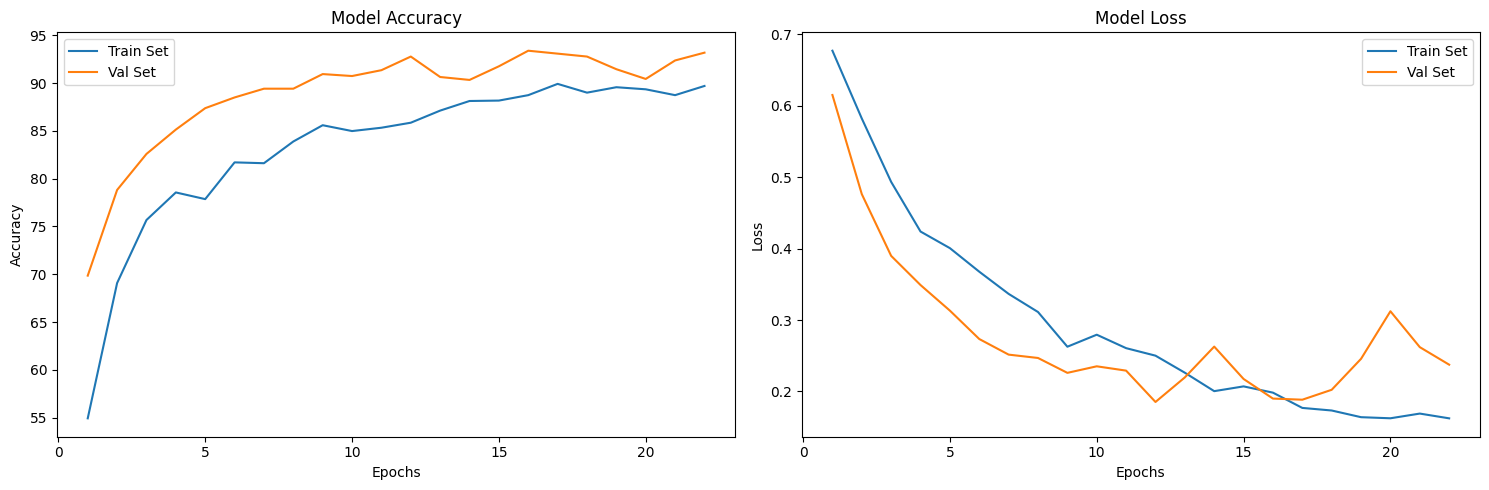

In [ ]:
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(15,5))

acc_train = [item.tolist() for item in train_accuracy]
acc_val = [item.tolist() for item in test_accuracy]

# plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_train, label='Train Set')
plt.plot(epochs, acc_val, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

# plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_avg, label='Train Set')
plt.plot(epochs, test_loss_avg, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

## Confusion Matrix

True positive = 451
False positive = 47
False negative = 20
True negative = 464



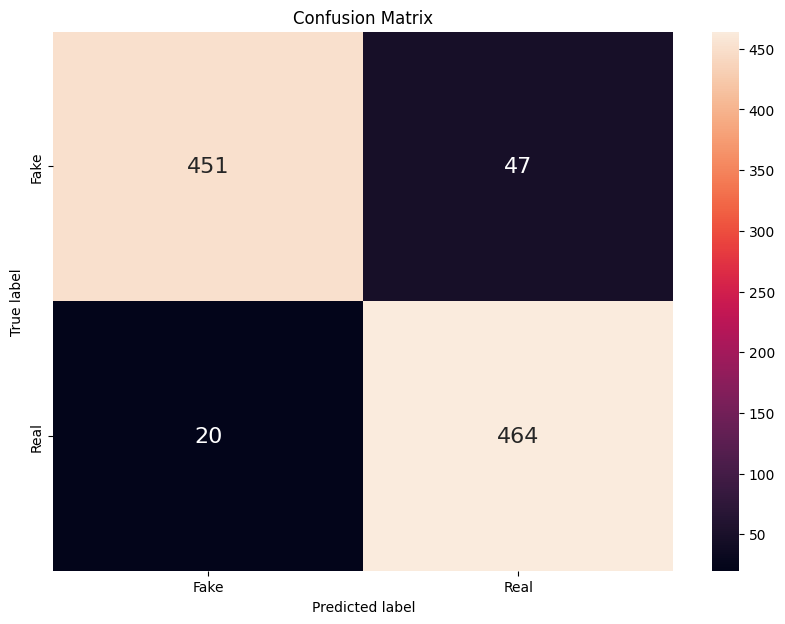

Calculated Accuracy: 93.17718940936864%


In [ ]:
# Display the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
print(f'True positive = {cm[0][0]}')
print(f'False positive = {cm[0][1]}')
print(f'False negative = {cm[1][0]}')
print(f'True negative = {cm[1][1]}\n')

df_cm = pd.DataFrame(cm, index=['Fake', 'Real'], columns=['Fake', 'Real'])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True, fmt='g', annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

calculated_acc = (cm[0][0] + cm[1][1]) / cm.sum() * 100
print(f"Calculated Accuracy: {calculated_acc}%")

## Class-wise Performance


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, pred_labels, target_names=['Fake', 'Real'])
print(report)

              precision    recall  f1-score   support

        Fake       0.96      0.91      0.93       498
        Real       0.91      0.96      0.93       484

    accuracy                           0.93       982
   macro avg       0.93      0.93      0.93       982
weighted avg       0.93      0.93      0.93       982



## ROC Curve and AUC


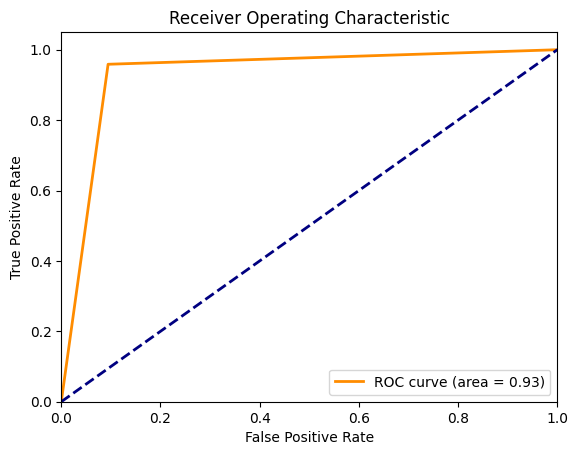

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Evaluation For **fifth** model (120 frames)

---




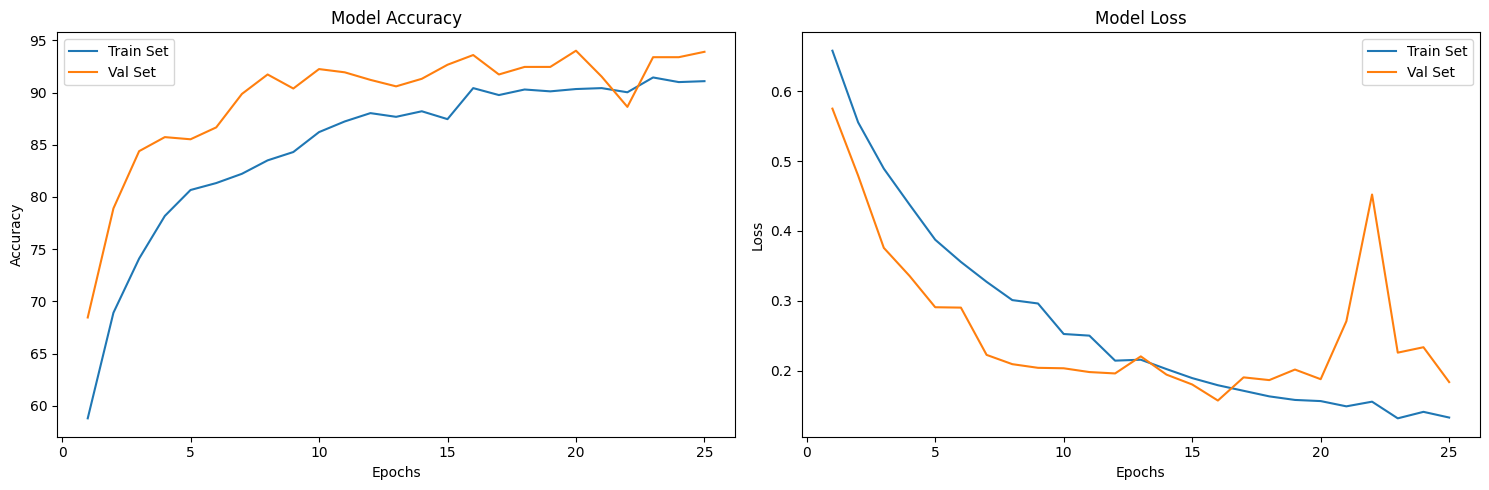

In [ ]:
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(15,5))

acc_train = [item.tolist() for item in train_accuracy]
acc_val = [item.tolist() for item in test_accuracy]

# plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_train, label='Train Set')
plt.plot(epochs, acc_val, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

# plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_avg, label='Train Set')
plt.plot(epochs, test_loss_avg, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

## Confusion Matrix

True positive = 406
False positive = 27
False negative = 32
True negative = 502



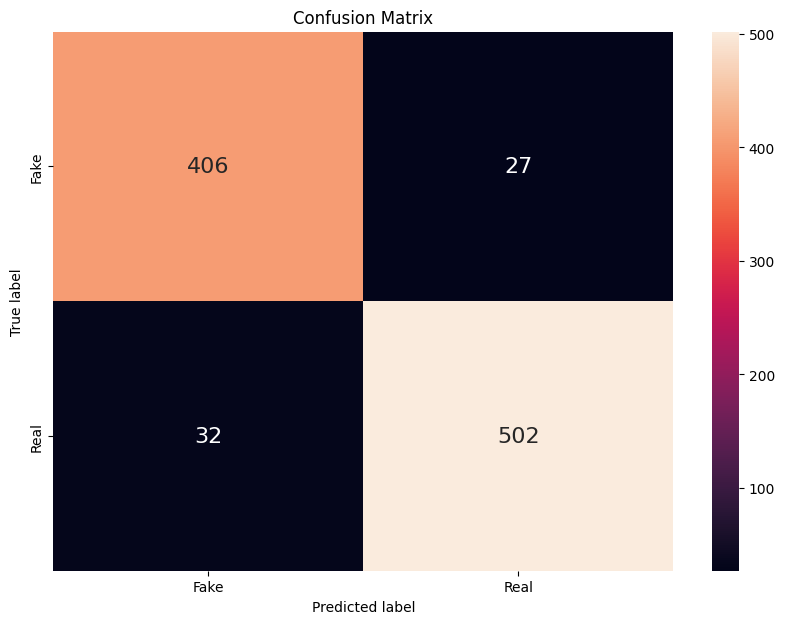

Calculated Accuracy: 93.8986556359876%


In [ ]:
# Display the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
print(f'True positive = {cm[0][0]}')
print(f'False positive = {cm[0][1]}')
print(f'False negative = {cm[1][0]}')
print(f'True negative = {cm[1][1]}\n')

df_cm = pd.DataFrame(cm, index=['Fake', 'Real'], columns=['Fake', 'Real'])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True, fmt='g', annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

calculated_acc = (cm[0][0] + cm[1][1]) / cm.sum() * 100
print(f"Calculated Accuracy: {calculated_acc}%")

## Class-wise Performance


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, pred_labels, target_names=['Fake', 'Real'])
print(report)

              precision    recall  f1-score   support

        Fake       0.93      0.94      0.93       433
        Real       0.95      0.94      0.94       534

    accuracy                           0.94       967
   macro avg       0.94      0.94      0.94       967
weighted avg       0.94      0.94      0.94       967



## ROC Curve and AUC


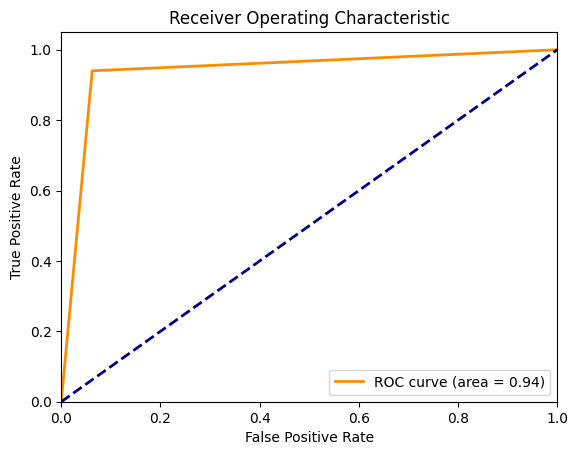

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()